# Experiment 2: Generalizing to commands demanding longer action sequences

Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/atnlp"

/content/drive/MyDrive/atnlp


In [3]:
import sys
from Dataset import SCANDataset, basic_tokenizer, tokenizer_bart, collate_fn
#from Exp2_Dataset import SCANData
#from Exp2_Dataset_2 import SCANData
from Utils import load_vocab, parse_dataset, parse_data_exp2, split_dataset, create_dataloader, greedy_decode, greedy_decode_single_oracle, greedy_decode_single, create_dataloader_exp2, create_dictionaries_exp2, plot_hist, train_bart, train_bart_exp2, enforce_reproducibility,  evaluate_bart_seq_lenght, oracle_decoder_input, evaluate_with_oracle, train_and_evaluate_with_oracle, evaluate_model_exp2, evaluate_model_exp2_oracle
#from Utils_2 import load_vocab, parse_dataset, parse_data_exp2, split_dataset, create_dataloader, create_dataloader_exp2, create_dictionaries_exp2, plot_hist, train_bart, train_bart_exp2, enforce_reproducibility, evaluate_bart_seq_lenght, evaluate_bart_seq_length_fixed
from oracle_code import Oracle
from Metrics import compute_accuracies
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn.utils import clip_grad_norm_
import random
from torch.utils.data import DataLoader, RandomSampler, Subset
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
import time

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Loading Vocabulary and Tokenizer<br />
- Tokenizer from Pretrained BART model is used

In [4]:
# loading vocab
input_vocab, output_vocab = load_vocab()

In [5]:
input_vocab_list = ['<PAD>','twice', 'and', 'look',  'thrice', 'left', 'turn', 'jump', 'run', 'opposite', 'walk', 'after', 'around', 'right', '<EOS>']
tokenizer = tokenizer_bart(input_vocab_list)


### Loading Pretrained BART and preparing model's configuration to finetune.

In [6]:

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
# Resize model's embeddings to accommodate new tokens
model.resize_token_embeddings(len(tokenizer))

# Modify specific parameters in the model's config
model.config.max_position_embeddings = 128  # Update max sequence length
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.pad_token_id
model.model.encoder.layers = model.model.encoder.layers[:2]


# Print the updated configuration
print("Updated Configuration:", model.config)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Updated Configuration: BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 50265,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
 

In [7]:
# Modify the configuration
# Reduce the number of decoder layers
model.model.decoder.layers = model.model.decoder.layers[:2]

# Update config to reflect the changes
model.config.d_model = 128  # Set the new d_model (embedding size)
model.config.encoder_layers = 2
model.config.decoder_layers = 2
model.config.encoder_attention_heads = 8  # Number of attention heads in the encoder
model.config.decoder_attention_heads = 8  # Number of attention heads in the decoder
model.config.dropout = 0.15               # Dropout rate
model.config.encoder_ffn_dim = 256        # Feedforward dimension in the encoder
model.config.decoder_ffn_dim = 256        # Feedforward dimension in the decoder
# Print updated configuration
print("Updated Configuration:", model.config)

Updated Configuration: BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 128,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 256,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 2,
  "decoder_start_token_id": 50265,
  "dropout": 0.15,
  "early_stopping": true,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 256,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 2,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-4 )
criterion = torch.nn.CrossEntropyLoss(ignore_index=output_vocab["<PAD>"])
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50270, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50270, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-1): 2 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

### Preparing Data for training: <br />
- Splitting data from train and test folders into two data files containing lengths of output action sequences.
- Loading the data files for Training

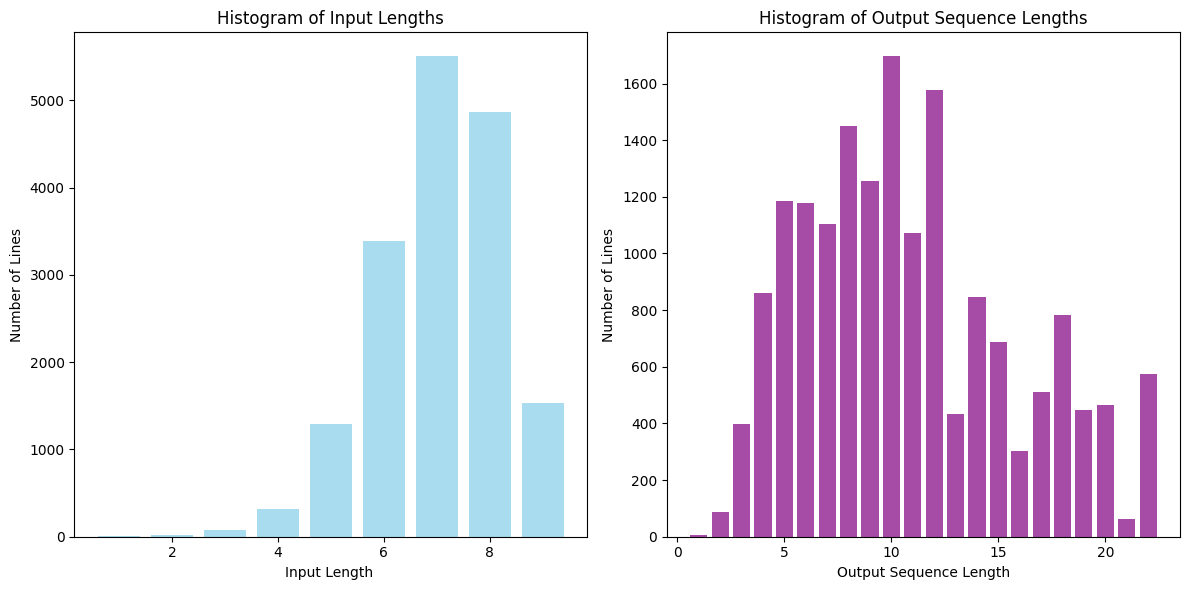

In [ ]:
# train data
train_path = 'data/tasks_train_length.txt'
parsed_trainset = parse_data_exp2(train_path)
train_command_dict, train_action_dict = create_dictionaries_exp2(parsed_trainset)

plot_hist(train_command_dict, train_action_dict)


# sorting dictionaries by key such as command and action lengths
sorted_train_command_dict = dict(sorted(train_command_dict.items()))  # Sorting by key
sorted_train_action_dict = dict(sorted(train_action_dict.items()))    # Sorting by key

train_command_lengths = sorted_train_command_dict.keys()
train_action_lengths = sorted_train_action_dict.keys()

# loading training data
train_command_loader = [create_dataloader_exp2(i, input_vocab, output_vocab, tokenizer, batch_size=16, shuffle = False) for j, i in sorted_train_command_dict.items()]
train_action_loader = [create_dataloader_exp2(i, input_vocab, output_vocab, tokenizer, batch_size=16, shuffle = False) for j, i in sorted_train_action_dict.items()]

# test data
val_path = 'data/tasks_test_length.txt'
parsed_val_set = parse_data_exp2(val_path)
val_command_dict, val_action_dict = create_dictionaries_exp2(parsed_val_set)

# Sort the dictionaries by key such as command and action length
sorted_val_command_dict = dict(sorted(val_command_dict.items()))  # Sorting by key
sorted_val_action_dict = dict(sorted(val_action_dict.items()))    # Sorting by key

val_command_lengths = sorted_val_command_dict.keys()
val_action_lengths = sorted_val_action_dict.keys()

# loading test data
val_command_loader = [create_dataloader_exp2(i, input_vocab, output_vocab, tokenizer, batch_size=16, shuffle = False) for j, i in sorted_val_command_dict.items()]
val_action_loader = [create_dataloader_exp2(i, input_vocab, output_vocab, tokenizer, batch_size=16, shuffle = False) for j, i in sorted_val_action_dict.items()]

### Training and Validation the tasks with BART

In [ ]:
epochs= 10
batch_size=16
lr= 2e-4
results= {}
grad_clip = 1.0
teacher_forcing_ratio = 0.5 # may or may not it for validation
token_accuracies = []
seq_accuracies = []

for epoch in range(epochs):
      print(f"\nTraining data")
      train_loss = train_bart_exp2(model, train_command_loader, train_action_loader, optimizer, device, grad_clip=1.0)
      print(f"Epoch {epoch+1}/{10}, Training Loss: {train_loss:.4f}")

      val_loss, token_acc, seq_acc, cmd_len_acc, act_len_acc = evaluate_bart_seq_lenght(
          model,
          val_command_loader,
          val_action_loader,
          device,
          tokenizer,
          start_token_id=3,
          eos_token_id=50269
          )
print(f"Validation Loss: {val_loss:.4f}, Token Accuracy: {token_acc:.4f}, Sequence Accuracy: {seq_acc:.4f}")
token_accuracies.append(token_acc)
seq_accuracies.append(seq_acc)

    # Calculate the average accuracy over the repetitions
avg_token_acc = sum(token_accuracies) / len(token_accuracies)
avg_seq_acc = sum(seq_accuracies) / len(seq_accuracies)
    # Store the results in the dictionary


print(f"Test Token-Level Accuracy: {token_acc:.8f}")
print(f"Test Sequence-Level Accuracy: {seq_acc:.8f}")


Training data


/content/drive/MyDrive/atnlp/Dataset.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seqs = [torch.tensor(item['input_ids']) for item in batch]
/content/drive/MyDrive/atnlp/Dataset.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_masks = [torch.tensor(item['input_attention_mask']) for item in batch]
/content/drive/MyDrive/atnlp/Dataset.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_seqs = [torch.tensor(item['target_ids']) for item in batch]
/content/drive/MyDrive/atnlp/Dataset.py:126: UserWarning: To c

Average Training Loss: 2.4033
Epoch 1/10, Training Loss: 2.4033

Training data
Average Training Loss: 0.0312
Epoch 2/10, Training Loss: 0.0312

Training data
Average Training Loss: 0.0207
Epoch 3/10, Training Loss: 0.0207

Training data
Average Training Loss: 0.0151
Epoch 4/10, Training Loss: 0.0151

Training data
Average Training Loss: 0.0143
Epoch 5/10, Training Loss: 0.0143

Training data
Average Training Loss: 0.0120
Epoch 6/10, Training Loss: 0.0120

Training data
Average Training Loss: 0.0112
Epoch 7/10, Training Loss: 0.0112

Training data
Average Training Loss: 0.0091
Epoch 8/10, Training Loss: 0.0091

Training data
Average Training Loss: 0.0084
Epoch 9/10, Training Loss: 0.0084

Training data
Average Training Loss: 0.0088
Epoch 10/10, Training Loss: 0.0088
Validation Loss: 5.9028, Token Accuracy: 0.9351, Sequence Accuracy: 0.1411
Test Token-Level Accuracy: 0.93510295
Test Sequence-Level Accuracy: 0.14114987


In [ ]:
print("Sequence level accuracies for act_len_acc, cmd_len_acc")

{128: 0.9287939361961198} {128: 0.9414446575007139}


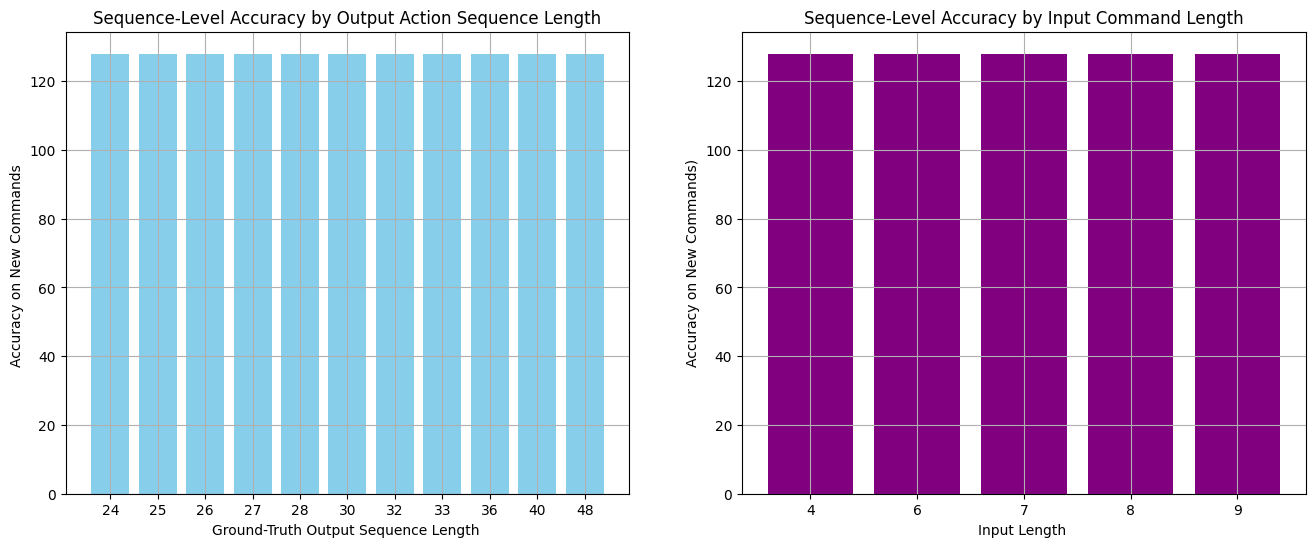

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    # Left subplot: Token-level accuracy (Action sequences) without oracle
axes[0].bar([f"{k}" for k in sorted_val_action_dict.keys()], act_len_acc, color='skyblue')
axes[0].set_xlabel('Ground-Truth Output Sequence Length ')
axes[0].set_ylabel('Accuracy on New Commands ')
axes[0].set_title('Sequence-Level Accuracy by Output Action Sequence Length')
axes[0].grid(True)

    # Right subplot: Token-level accuracy (Command sequences) without oracle
axes[1].bar([f"{k}" for k in sorted_val_command_dict.keys()], cmd_len_acc, color='purple')
axes[1].set_xlabel('Input Length ')
axes[1].set_ylabel('Accuracy on New Commands)')
axes[1].set_title('Sequence-Level Accuracy by Input Command Length')
axes[1].grid(True)

### Loading data for oracle implementation

In [9]:
df = parse_dataset('data/tasks.txt', input_vocab, output_vocab)
df['OUT_len'] = df['OUT'].apply(lambda x: len(x.split()))
# Filter the dataframe based on OUT_len
train_df = df[df['OUT_len'] < 23].reset_index(drop=True)
val_df = df[df['OUT_len'] >= 23].reset_index(drop=True)

print("Train len should be 16990:", (train_df.shape[0] ) == 16990, "\nval len should be 3920:", val_df.shape[0] == 3920)

Train len should be 16990: True 
val len should be 3920: True


In [10]:
# Initialize the dataset and dataloader
train_dataset = SCANDataset(train_df, input_vocab, output_vocab, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Initialize the dataset and dataloader
val_dataset = SCANDataset(val_df, input_vocab, output_vocab, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

eval_dataset = SCANDataset(val_df, input_vocab, output_vocab, tokenizer)
eval_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [11]:
def train_epoch(model, loader, criterion, optimizer, grad_clip):
    model.train()
    total_loss = 0
    for batch in loader:
        src = batch['input_ids'].to(device)
        tgt = batch['target_ids'].to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:].contiguous().view(-1)

        optimizer.zero_grad()

        # Forward pass without teacher forcing
        outputs = model(src, tgt_input) # get the Seq2SeqLMOutput object
        logits = outputs.logits # access the logits

        loss = criterion(logits.view(-1, logits.size(-1)), tgt_output) # apply view on logits
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [15]:
epochs = 10
grad_clip = 1.0
teacher_forcing = False
best_tok_acc = 0
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(tqdm(train_dataloader)):
        src_in = batch['input_ids'].to(device)
        tgt_in = batch['target_ids'].to(device)

        # Get the model output, which is a Seq2SeqLMOutput object
        outputs = model(src_in, tgt_in[:, :-1])

        # Access the logits from the outputs object
        logits = outputs.logits

        # Compute loss
        loss = criterion(logits.view(-1, logits.size(-1)), tgt_in[:, 1:].contiguous().view(-1))
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()





    model.eval()
    with torch.no_grad():
        token_acc = 0
        seq_acc = 0
        for batch in tqdm(val_dataloader):

            src_in_val = batch['input_ids'].to(device)
            tgt_in_val = batch['target_ids'].to(device)

            if teacher_forcing:

                logits = model(src_in_val, tgt_in_val[:, :-1])
                output_val = logits.argmax(dim=-1)

            else:
                # Generate predictions without teacher forcing
                output_val = greedy_decode(
                    model,
                    src_in_val,
                    max_len=tgt_in_val.size(1),  # Maximum length of the target sequence
                    start_token_id=3,
                    eos_token_id=50269

                )

            # Compute accuracy
            token_acc_batch, seq_acc_batch = compute_accuracies(output_val, tgt_in_val[:, 1:])
            token_acc += token_acc_batch
            seq_acc += seq_acc_batch

        if token_acc / len(val_dataloader) > best_tok_acc:
            print("Saving model")
            best_tok_acc = token_acc / len(val_dataloader)
            torch.save(model.state_dict(), "Archive/models/best_model_experiment2.pth")

        print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss/len(train_dataloader)} Token Acc: {token_acc/len(val_dataloader)} Seq Acc: {seq_acc/len(val_dataloader)}")

100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Saving model
Epoch 1/10 Loss: 0.18724929043942476 Token Acc: 0.0005261479591836735 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Saving model
Epoch 2/10 Loss: 0.12634932065273857 Token Acc: 0.006020806760204082 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Epoch 3/10 Loss: 0.09857651179133724 Token Acc: 0.0020169005102040815 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Epoch 4/10 Loss: 0.08259369916301887 Token Acc: 0.0005261479591836735 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Epoch 5/10 Loss: 0.07845059002832055 Token Acc: 0.0005261479591836735 Seq Acc: 0.0


100%|██████████| 245/245 [06:56<00:00,  1.70s/it]


Saving model
Epoch 6/10 Loss: 0.06872745036110703 Token Acc: 0.008338647959183673 Seq Acc: 0.0


100%|██████████| 245/245 [06:55<00:00,  1.69s/it]


Epoch 7/10 Loss: 0.06576769000617348 Token Acc: 0.008338647959183673 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Saving model
Epoch 8/10 Loss: 0.06379976115854222 Token Acc: 0.02828842474489796 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]


Epoch 9/10 Loss: 0.06181459999494184 Token Acc: 0.011017219387755102 Seq Acc: 0.0


100%|██████████| 245/245 [06:54<00:00,  1.69s/it]

Epoch 10/10 Loss: 0.06158752715927172 Token Acc: 0.008338647959183673 Seq Acc: 0.0
